In [355]:
# importing and downloading necessary modules

import pandas as pd
import numpy as np
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('punkt')
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
from collections import Counter
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import LinearSVC

In [356]:
# Loading data, using 1000 of each positive and negative reviews
df = pd.read_csv(r"IMDB Dataset.csv")
df_positive= df[df['sentiment'] == 'positive'].head(1000)
df_negative= df[df['sentiment'] == 'negative'].head(1000)
df = pd.concat([df_positive, df_negative])
# print(df.info())

In [357]:
#Variables for data cleaning

# regular expression to remove characters that are not letters or spaces
regex = re.compile('[^a-zA-Z ]')

# stopwords
stopwords = stopwords.words('english')
stopwords_no_punct = [regex.sub('', word) for word in stopwords]
stopwords_no_punct.append("br")
stopwords_new = set(stopwords + stopwords_no_punct)

In [358]:
# Data cleaning

df['review_cleaned'] = df['review'].astype("string").apply(lambda x: regex.sub('', x))
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: " ".join(x.split()))
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: word_tokenize(x.lower()))
df['review_cleaned'] = df['review_cleaned'].apply(lambda x: [word for word in x if word not in stopwords_new])

# print(df.head(10))

In [359]:
# POS taging

df['tagged'] = df['review_cleaned'].apply(lambda x: nltk.pos_tag(x))

In [360]:
# POS count
pos_count_by_type = {}

for group_value, group_df in df.groupby("sentiment"):
    tags = [tag for row in group_df["tagged"] for (_, tag) in row]
    pos_count_by_type[group_value] = Counter(tags)

# print(pos_count_by_type)

In [361]:
# POS dataframe
pos_df = pd.DataFrame(pos_count_by_type).reset_index()
pos_df.rename(columns={'index':'pos'}, inplace=True)

# top 10 positive POS
pos_positive = pos_df[['pos', 'positive']].sort_values(by='positive', ascending=False).head(10)
pos_positive = pos_positive.sort_values(by='positive') # just for plotting

# top 10 negative POS
pos_negative = pos_df[['pos', 'negative']].sort_values(by='negative', ascending=False).head(10)

# merge positive and negative
pos_df = pos_positive.merge(pos_negative, on='pos', how='inner')
pos_df = pos_df.sort_values(by='positive', ascending=False)

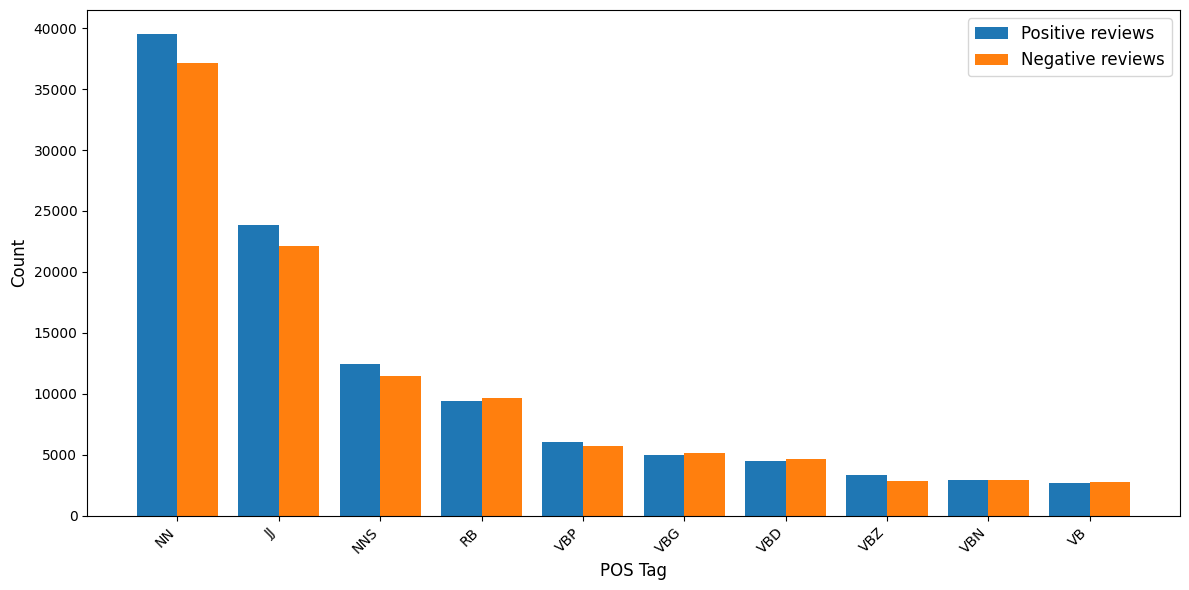

In [362]:
# POS visualization
x = np.arange(len(pos_df['pos']))

width = 0.4

fig_pos, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width/2, pos_df['positive'], width, label='Positive reviews')
ax.bar(x + width/2, pos_df['negative'], width, label='Negative reviews')

ax.set_xlabel('POS Tag', fontsize= 12)
ax.set_ylabel('Count', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(pos_df['pos'], rotation=45, ha='right')
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()
# fig_pos.savefig('pos_chart.png')

In [363]:
# Lemmatization
nlp = spacy.load("en_core_web_sm")

lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df['review_cleaned'].apply(lambda x: [word.lemma_ for word in nlp(' '.join(x))])
# print(df.head())

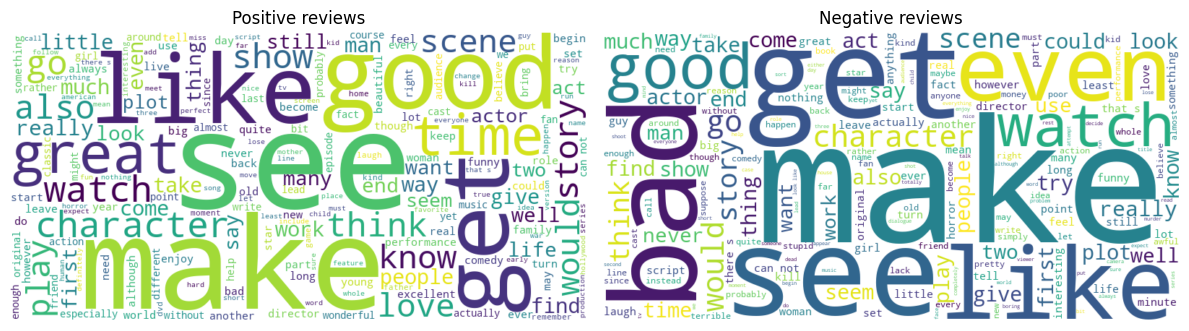

In [364]:
# wordcloud

exclude_words = ['film', 'movie', 'one']

positive_df = df[df['sentiment'] == 'positive']
negative_df = df[df['sentiment'] == 'negative']

positive_text = [word for row in positive_df['lemmatized'] for word in row]
positive_text = " ".join(positive_text)

negative_text = [word for row in negative_df['lemmatized'] for word in row]
negative_text = " ".join(negative_text)

wordcloud_positive = WordCloud(width=800,
                               height=400,
                               background_color='white',
                               stopwords=exclude_words).generate(positive_text)
wordcloud_negative = WordCloud(width=800,
                               height=400,
                               background_color='white',
                               stopwords=exclude_words).generate(negative_text)

worldcloud_fig = plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title("Positive reviews")

plt.subplot(1,2,2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title("Negative reviews")
plt.tight_layout()

plt.show()
# worldcloud_fig.savefig('worldcloud.png')

In [365]:
corpus = df['lemmatized'].apply(" ".join).to_list()
# print(corpus)

# encoding sentiment as 0/1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['sentiment'])
# print(Y)

# vectorization using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(corpus)
# print(X)

In [366]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)

# logistic regression

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr, average='weighted')
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(f"Accuracy LR: {accuracy_lr:}")
print(f"Precision LR: {precision_lr:}")
print(f"Recall LR: {recall_lr:}")
print(f"F1 score LR: {f1_lr:}")
print(f"Confusion matrix LR: {cm_lr:}")

Accuracy LR: 0.7725
Precision LR: 0.7767926454279666
Recall LR: 0.7725
F1 score LR: 0.7720744098453991
Confusion matrix LR: [[148  57]
 [ 34 161]]


In [367]:
# SVM

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
cm_svm = confusion_matrix(y_test, y_pred_svm)
print(f"Accuracy SVM: {accuracy_svm:}")
print(f"Precision SVM: {precision_svm:}")
print(f"Recall SVM: {recall_svm:}")
print(f"F1 score SVM: {f1_svm:}")
print(f"Confusion matrix SVM: {cm_svm:}")

Accuracy SVM: 0.7475
Precision SVM: 0.7480241774177417
Recall SVM: 0.7475
F1 score SVM: 0.7475331424892651
Confusion matrix SVM: [[151  54]
 [ 47 148]]


In [368]:
# finding strongest features in the model that deteremine positive/negative review prediction

feature_names = vectorizer.get_feature_names_out()

# LR
coefficients_lr = model_lr.coef_[0]
coef_svm = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients_lr
})


top_positive = coef_svm.sort_values(by='coefficient', ascending=False).head(10)
print(top_positive)

top_negative = coef_svm.sort_values(by='coefficient', ascending=True).head(10)
print(top_negative)


             word  coefficient
1970        great     3.047247
2659         love     2.725759
1554    excellent     2.243260
4232        still     1.695026
4933    wonderful     1.616661
1481        enjoy     1.389558
1517   especially     1.323791
1662     favorite     1.318362
3247  performance     1.247728
3243      perfect     1.228786
          word  coefficient
346        bad    -4.933201
4830     waste    -2.381504
335      awful    -1.798016
1530      even    -1.717916
514     boring    -1.666437
3316      plot    -1.556887
3046   nothing    -1.537983
4437  terrible    -1.463457
997      could    -1.458670
2510      lack    -1.318640


In [369]:
# SVM

coefficients_svm = svm_model.coef_[0]

coef_svm = pd.DataFrame({
    'word': feature_names,
    'coefficient': coefficients_svm
})

# coef_df

top_positive = coef_svm.sort_values(by='coefficient', ascending=False).head(10)
print(top_positive)

top_negative = coef_svm.sort_values(by='coefficient', ascending=True).head(10)
print(top_negative)


            word  coefficient
1554   excellent     2.366937
1970       great     2.339479
2659        love     1.994769
4232       still     1.718854
4933   wonderful     1.488488
1662    favorite     1.337381
1874         gem     1.311797
1481       enjoy     1.291967
1517  especially     1.285787
804      classic     1.259261
          word  coefficient
346        bad    -3.411771
4830     waste    -2.110264
514     boring    -1.643928
335      awful    -1.634034
2510      lack    -1.545369
3837      save    -1.306901
4437  terrible    -1.294118
2302   instead    -1.285881
3046   nothing    -1.247994
1366      dull    -1.197348
